In [1]:
# Cài đặt và Import thư viện
import random
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import time
import sys
from heapq import heappush, heappop
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
print("Các thư viện đã được import.")

Các thư viện đã được import.


In [2]:
# Đo thời gian tổng
start_time_total = time.time()

# Data Generation và Shingling
def generate_random_string(min_len, max_len):
    length = random.randint(min_len, max_len)
    return ''.join(random.choice(string.ascii_lowercase) for _ in range(length))

def get_shingles(text, k=4):
    shingles = set()
    if text is None or len(text) < k:
        return shingles
    for i in range(len(text) - k + 1):
        shingles.add(text[i:i+k])
    return shingles

# Thông số
NUM_TOTAL_STRINGS = 10000
MIN_LENGTH = 32
MAX_LENGTH = 64
SHINGLE_K = 4
CSV_FILENAME = "generated_strings_with_shingles.csv"
SAMPLE_SIZE_FOR_CLUSTERING = 10000  # Giảm để thử nghiệm, tăng lên 10000 sau khi tối ưu
NUM_FINAL_CLUSTERS_TARGET = 5

print("--- Bước 1: Tạo dữ liệu và Shingling ---")
start_time = time.time()
data_to_generate = []
for i in range(NUM_TOTAL_STRINGS):
    original_string = generate_random_string(MIN_LENGTH, MAX_LENGTH)
    shingles_set = get_shingles(original_string, k=SHINGLE_K)
    data_to_generate.append({
        "index": i,
        "string": original_string,
        "shingles": shingles_set
    })

df_generated_all = pd.DataFrame(data_to_generate)
df_to_save_csv = df_generated_all.copy()
df_to_save_csv['shingles'] = df_to_save_csv['shingles'].apply(lambda s: list(s))
df_to_save_csv.to_csv(CSV_FILENAME, index=False)
print(f"Đã tạo và lưu {len(df_generated_all)} chuỗi vào file '{CSV_FILENAME}'.")
print(f"Thời gian tạo dữ liệu: {time.time() - start_time:.2f} giây")
print("-" * 30)

--- Bước 1: Tạo dữ liệu và Shingling ---
Đã tạo và lưu 10000 chuỗi vào file 'generated_strings_with_shingles.csv'.
Thời gian tạo dữ liệu: 0.58 giây
------------------------------


In [3]:
#Jaccard Distance Function
# Yêu cầu: Dùng Jaccard distance để đo sự khác biệt
def jaccard_distance(set1, set2):
    if not isinstance(set1, set):
        set1 = set(set1)
    if not isinstance(set2, set):
        set2 = set(set2)
    intersection_len = len(set1.intersection(set2))
    union_len = len(set1.union(set2))
    if union_len == 0:
        return 1.0  # Đề yêu cầu 1.0 cho trường hợp rỗng
    return 1.0 - intersection_len / union_len

print("\n--- Bước 2: Định nghĩa hàm Jaccard Distance ---")
# Test nhỏ (có thể bỏ qua khi nộp bài)
set_a = {'a', 'b', 'c'}
set_b = {'b', 'c', 'd'}
print(f"Test Jaccard Distance (A, B): {jaccard_distance(set_a, set_b)}") # Expected: 0.5
set_c = {'x', 'y'}
print(f"Test Jaccard Distance (A, C): {jaccard_distance(set_a, set_c)}") # Expected: 1.0
print(f"Test Jaccard Distance (A, A): {jaccard_distance(set_a, set_a)}") # Expected: 0.0
print("-" * 30)


--- Bước 2: Định nghĩa hàm Jaccard Distance ---
Test Jaccard Distance (A, B): 0.5
Test Jaccard Distance (A, C): 1.0
Test Jaccard Distance (A, A): 0.0
------------------------------


In [4]:
class AgglomerativeHierarchicalClustering:
    def __init__(self, distance_metric_func): 
        self.distance_metric = distance_metric_func # jaccard_distance
        self.samples_data = [] # List các shingle sets gốc
        
       
        # Sử dụng ID cụm ổn định
        self.active_cluster_ids = set() # Set các ID của các cụm đang hoạt động
        self.cluster_members_map = {}   # Dict: cluster_id -> tuple_of_original_sample_indices các chỉ số mẫu gốc thuộc cụm đó.
        self.clustroids_map = {}        # Dict: cluster_id -> original_sample_index_of_clustroid chỉ số mẫu gốc làm clustroid cho cụm đó.
        self.next_internal_cluster_id = 0 # Để tạo ID cụm duy nhất (số nguyên)

        self._sample_distance_cache = {}  # Cache khoảng cách Jaccard giữa các MẪU gốc

    def _get_cached_sample_distance(self, original_sample_idx1, original_sample_idx2):#dùng cache để tránh tính toán nhiều lần
        # original_sample_idx1, original_sample_idx2 là chỉ số trong self.samples_data
        # dùng khoảng cách mẫu gốc để tính 
        key = tuple(sorted((original_sample_idx1, original_sample_idx2))) #Tạo key duy nhất cho cặp mẫu trong cache. -> Dù là (0,1) hay (1,0), key luôn là (0,1) → đảm bảo đối xứng và tránh trùng lặp
        if key not in self._sample_distance_cache: # Nếu chưa có khoảng cách này trong cache, ta phải tính toán và lưu lại.
            dist = self.distance_metric(self.samples_data[original_sample_idx1], 
                                        self.samples_data[original_sample_idx2])
            self._sample_distance_cache[key] = dist
        return self._sample_distance_cache[key]

    def _calculate_clustroid_strictly(self, cluster_original_sample_indices):
        """
        Tính clustroid chặt chẽ: điểm trong cụm có TỔNG BÌNH PHƯƠNG KHOẢNG CÁCH
        nhỏ nhất đến TẤT CẢ các điểm khác trong cụm.
        Tìm clustroid: điểm đại diện cho cụm là mẫu có tổng bình phương khoảng cách đến tất cả các mẫu khác trong cụm là nhỏ nhất.
        cluster_original_sample_indices: list/tuple các index của sample trong self.samples_data.
        Trả về original_sample_index của clustroid.
        """
        if not cluster_original_sample_indices: # Danh sách các chỉ số (index) của mẫu trong cụm.
            return None
        num_members = len(cluster_original_sample_indices)
        if num_members == 1: # Nếu cụm chỉ có 1 phần tử → nó chính là clustroid
            return cluster_original_sample_indices[0]

        #Đi tìm clustroid
        min_sum_sq_dist_to_others = float('inf')
        best_clustroid_original_idx = cluster_original_sample_indices[0] # Khởi tạo fallback

        # Duyệt TẤT CẢ các điểm trong cụm làm ứng viên clustroid
        for potential_clustroid_original_idx in cluster_original_sample_indices:
            current_sum_sq_dist = 0
            for member_original_idx in cluster_original_sample_indices:
                if member_original_idx == potential_clustroid_original_idx:
                    continue
                # Sử dụng khoảng cách giữa các mẫu gốc
                dist = self._get_cached_sample_distance(potential_clustroid_original_idx, member_original_idx)
                current_sum_sq_dist += (dist ** 2) # TÍNH TỔNG BÌNH PHƯƠNG KHOẢNG CÁCH
            
            if current_sum_sq_dist < min_sum_sq_dist_to_others:
                min_sum_sq_dist_to_others = current_sum_sq_dist
                best_clustroid_original_idx = potential_clustroid_original_idx
        # Ví dụ
        # samples_data[0] = {'the', 'cat', 'sat'} (0,1): ~0.5 Mẫu 0: 0.5² + 0.75² = 0.8125 
        # samples_data[1] = {'cat', 'sat', 'on'} (0,2): ~0.75 Mẫu 1: 0.5² + 0.8² = 0.89
        # samples_data[2] = {'dog', 'sat', 'mat'} (1,2): ~0.8 Mẫu 2: 0.75² + 0.8² = 1.2025
        # => Mẫu 0 là clustroid vì có tổng khoảng cách nhỏ nhất.
        return best_clustroid_original_idx

    def _get_inter_cluster_distance_centroid(self, internal_cluster_id1, internal_cluster_id2):
        """
        Tính khoảng cách giữa hai cụm DỰA TRÊN KHOẢNG CÁCH GIỮA CLUSTROID CỦA CHÚNG.
        internal_cluster_id1, internal_cluster_id2 là các ID số nguyên nội bộ của cụm.
        Trong thuật toán Agglomerative Clustering, ta cần đo khoảng cách giữa các cụm để biết cụm nào nên gộp.
        """
        # Lấy chỉ số mẫu gốc của clustroid cho mỗi cụm
        clustroid_original_idx1 = self.clustroids_map[internal_cluster_id1]
        clustroid_original_idx2 = self.clustroids_map[internal_cluster_id2]
        
        #Ví dụ
        #self.clustroids_map = {0: 4,  # Cụm 0 đại diện bởi mẫu gốc số 4
                                #1: 7   # Cụm 1 đại diện bởi mẫu gốc số 7}
        
        # Trả về khoảng cách Jaccard (đã cache) giữa hai clustroid này
        return self._get_cached_sample_distance(clustroid_original_idx1, clustroid_original_idx2)

    def _calculate_cluster_diameter(self, member_indices):
        """
        Tính đường kính của một cụm = khoảng cách lớn nhất giữa 2 phần tử trong cụm.
        """
        max_dist = 0
        for i in range(len(member_indices)):
            for j in range(i + 1, len(member_indices)):
                idx1 = member_indices[i]
                idx2 = member_indices[j]
                dist = self._get_cached_sample_distance(idx1, idx2)
                max_dist = max(max_dist, dist)
        return max_dist

    
    def fit(self, input_shingle_sets, num_target_clusters=None):
        
        fit_start_time = time.time()
        self.samples_data = input_shingle_sets # Nhận vào các tập shingle (dạng set).
        num_initial_samples = len(self.samples_data)
        if num_initial_samples == 0: # Không có dữ liệu:
            print("No samples to cluster.")
            return []
        if num_target_clusters is None or num_target_clusters <= 0: # Số cụm yêu cầu không hợp lệ:
            num_target_clusters = 1 # Mặc định hoặc xử lý lỗi
            print(f"Warning: num_target_clusters invalid, set to {num_target_clusters}")
        if num_target_clusters >= num_initial_samples: #Yêu cầu nhiều cụm hơn hoặc bằng số mẫu → mỗi mẫu là 1 cụm: Trả về luôn mà không gom cụm.
            print(f"Target clusters ({num_target_clusters}) >= samples ({num_initial_samples}). Each sample is a cluster.")
            # Trả về mỗi mẫu là một cụm
            final_clusters_members = []
            for i in range(num_initial_samples):
                self.cluster_members_map[i] = tuple([i])
                self.clustroids_map[i] = i # Clustroid là chính nó
                final_clusters_members.append(list(self.cluster_members_map[i]))
            self.active_cluster_ids = set(range(num_initial_samples))
            self.next_internal_cluster_id = num_initial_samples
            print(f"--- Clustering (no merge) finished in {time.time() - fit_start_time:.2f} seconds ---")
            return final_clusters_members


        # Reset state cho mỗi lần fit
        self.active_cluster_ids = set()
        self.cluster_members_map = {}
        self.clustroids_map = {}
        self._sample_distance_cache = {} # Xóa cache cũ nếu fit nhiều lần
        self.next_internal_cluster_id = 0

        print(f"Initializing {num_initial_samples} clusters...")
        # Khởi tạo: mỗi mẫu là một cụm, gán ID nội bộ (số nguyên)
        for i in range(num_initial_samples): #Tạo mỗi mẫu ban đầu là 1 cụm
            internal_id = self.next_internal_cluster_id
            self.active_cluster_ids.add(internal_id)
            # Lưu các chỉ số mẫu gốc thuộc về internal_id này
            self.cluster_members_map[internal_id] = tuple([i]) 
            # Tính clustroid (chỉ số mẫu gốc) cho cụm 1 điểm này
            self.clustroids_map[internal_id] = self._calculate_clustroid_strictly(self.cluster_members_map[internal_id])
            self.next_internal_cluster_id += 1
        
        # Sử dụng priority queue (min-heap)
        heap = []
        print("Calculating initial pairwise cluster distances for heap...")
        # Lấy danh sách các ID cụm đang hoạt động (số nguyên)
        current_active_ids_list = list(self.active_cluster_ids)
        for i in range(len(current_active_ids_list)): #Tính khoảng cách giữa các cụm ban đầu
            for j in range(i + 1, len(current_active_ids_list)):
                id1_internal = current_active_ids_list[i]
                id2_internal = current_active_ids_list[j]
                # Sử dụng hàm tính khoảng cách mới dựa trên clustroid
                dist = self._get_inter_cluster_distance_centroid(id1_internal, id2_internal)
                # Đẩy ID cụm (số nguyên) vào heap Dùng heap để lưu (khoảng cách, id1, id2)
                heappush(heap, (dist, id1_internal, id2_internal))

        num_merges_to_perform = num_initial_samples - num_target_clusters
        merged_count = 0
        threshold_ratio = 1.2
        stopped_by_diameter = False
        print(f"INFO: Starting clustering. Target: {num_target_clusters} clusters. Initial: {len(self.active_cluster_ids)} clusters. Threshold ratio for diameter stop: {threshold_ratio}")
        while len(self.active_cluster_ids) > num_target_clusters: #Vòng lặp chính: gộp cụm
            merged_count += 1
            if not heap:
                print("Heap is empty, but target number of clusters not reached. Stopping.")
                break
            
            dist, c1_internal_id, c2_internal_id = heappop(heap)
            
            if c1_internal_id not in self.active_cluster_ids or c2_internal_id not in self.active_cluster_ids:
                continue

            
            # Lazy deletion: nếu một trong hai cụm đã bị gộp (không còn trong active_cluster_ids), bỏ qua
            if c1_internal_id not in self.active_cluster_ids or \
               c2_internal_id not in self.active_cluster_ids:
                continue 


            # Thực hiện gộp 2 cụm thành cụm mới
            # Lấy danh sách các chỉ số mẫu gốc từ hai cụm cũ
            members_c1 = self.cluster_members_map[c1_internal_id]
            members_c2 = self.cluster_members_map[c2_internal_id]
            # Gộp các chỉ số mẫu gốc, loại bỏ trùng lặp và sắp xếp
            new_cluster_original_sample_indices = tuple(sorted(list(set(members_c1 + members_c2))))

            diameter_c1 = self._calculate_cluster_diameter(list(members_c1))
            diameter_c2 = self._calculate_cluster_diameter(list(members_c2))
            prev_max_diameter = max(diameter_c1, diameter_c2)
            new_diameter = self._calculate_cluster_diameter(list(new_cluster_original_sample_indices))
            
            if len(members_c1) > 0 and len(members_c2) > 0 : # Chỉ tính đường kính nếu cụm không rỗng
                diameter_c1 = self._calculate_cluster_diameter(list(members_c1))
                diameter_c2 = self._calculate_cluster_diameter(list(members_c2))
                prev_max_diameter = max(diameter_c1, diameter_c2) if diameter_c1 is not None and diameter_c2 is not None else 0
                
                if prev_max_diameter is not None: # chỉ tính new_diameter nếu prev_max_diameter hợp lệ
                    new_diameter = self._calculate_cluster_diameter(list(new_cluster_original_sample_indices))
                    if new_diameter is not None and prev_max_diameter > 0 and threshold_ratio * prev_max_diameter > 0: # Thêm kiểm tra để tránh lỗi
                        if new_diameter > threshold_ratio * prev_max_diameter :
                            print(f"INFO: Stopping early due to diameter condition!")
                            print(f"       Previous max diameter: {prev_max_diameter:.4f}, New diameter: {new_diameter:.4f} (Ratio: {new_diameter/prev_max_diameter:.2f} > {threshold_ratio})")
                            print(f"Stopping early: Diameter jumped from {prev_max_diameter:.4f} to {new_diameter:.4f}. Clusters remaining: {len(self.active_cluster_ids)}")
                            stopped_by_diameter = True
                            break
                else: # Nếu không tính được prev_max_diameter (ví dụ cụm rỗng), không áp dụng điều kiện dừng này
                    pass
            
            # Tạo ID nội bộ mới cho cụm gộp 
            new_internal_cluster_id = self.next_internal_cluster_id
            self.next_internal_cluster_id += 1
            
            # Cập nhật thông tin cho cụm mới
            self.cluster_members_map[new_internal_cluster_id] = new_cluster_original_sample_indices
            # Tính clustroid (chỉ số mẫu gốc) cho cụm mới gộp
            new_clustroid_original_idx = self._calculate_clustroid_strictly(new_cluster_original_sample_indices)
            self.clustroids_map[new_internal_cluster_id] = new_clustroid_original_idx
            
            # Cập nhật trạng thái các cụm Xoá cụm cũ, thêm cụm mới
            self.active_cluster_ids.remove(c1_internal_id)
            self.active_cluster_ids.remove(c2_internal_id)
            del self.cluster_members_map[c1_internal_id] 
            del self.cluster_members_map[c2_internal_id]
            del self.clustroids_map[c1_internal_id]
            del self.clustroids_map[c2_internal_id]

            self.active_cluster_ids.add(new_internal_cluster_id)
            
            # Cập nhật heap:
            # Thêm khoảng cách từ cụm mới (new_internal_cluster_id) đến tất cả các cụm active khác
            for other_active_internal_id in self.active_cluster_ids:
                if other_active_internal_id != new_internal_cluster_id:
                    dist_new_to_other = self._get_inter_cluster_distance_centroid(new_internal_cluster_id, other_active_internal_id)
                    # Đẩy ID cụm (số nguyên) vào heap, đảm bảo thứ tự để tránh trùng lặp (mặc dù lazy deletion sẽ xử lý)
                    heappush(heap, (dist_new_to_other, 
                                    min(new_internal_cluster_id, other_active_internal_id), 
                                    max(new_internal_cluster_id, other_active_internal_id)))
        
        fit_duration = time.time() - fit_start_time
        print(f"--- Clustering finished in {fit_duration:.2f} seconds ---")
        if stopped_by_diameter:
            print(f"INFO: Clustering stopped early by diameter condition.")
        elif len(self.active_cluster_ids) == num_target_clusters:
            print(f"INFO: Clustering reached target number of {num_target_clusters} clusters.")
        else:
            print(f"INFO: Clustering stopped for other reasons (e.g., heap empty). Clusters remaining: {len(self.active_cluster_ids)}")
        print(f"Final number of active_cluster_ids: {len(self.active_cluster_ids)}")
        # Trả về danh sách các cụm cuối cùng, mỗi cụm là list các chỉ số mẫu gốc
        final_clusters_members_list = []
        for active_id in self.active_cluster_ids:
            final_clusters_members_list.append(list(self.cluster_members_map[active_id]))
        return final_clusters_members_list

    def get_final_cluster_details(self): 
        """
        Lấy thông tin chi tiết cho các cụm cuối cùng (sau khi fit đã chạy).
        """
        detailed_clusters = []
        if not self.active_cluster_ids: # Kiểm tra xem có cụm nào active không
             print("No active clusters found to get details for.")
             return []

        print("\n--- Final Cluster Details ---")
        # Sắp xếp active_cluster_ids để output có thứ tự (tùy chọn)
        sorted_active_ids = sorted(list(self.active_cluster_ids))

        for i, internal_cluster_id in enumerate(sorted_active_ids):
            member_original_indices = list(self.cluster_members_map[internal_cluster_id]) # Lấy các chỉ số mẫu gốc thuộc cụm:
            shingles_in_this_cluster = [self.samples_data[idx] for idx in member_original_indices] # Lấy các shingle sets tương ứng từ self.samples_data
            
            clustroid_original_idx = self.clustroids_map.get(internal_cluster_id) #  Lấy thông tin clustroid
            clustroid_shingles = self.samples_data[clustroid_original_idx] if clustroid_original_idx is not None else None
            
#             print(f"Final Cluster {i} (Internal ID: {internal_cluster_id}): Size={len(member_original_indices)}, Clustroid Sample Idx={clustroid_original_idx}") #In ra thông tin cụm

            #Thêm vào danh sách kết quả
            detailed_clusters.append({
                "internal_id": internal_cluster_id, # ID nội bộ của cụm
                "member_original_indices": member_original_indices,
                "member_shingle_sets": shingles_in_this_cluster,
                "clustroid_original_sample_index": clustroid_original_idx,
                "clustroid_shingles": clustroid_shingles
            })
        return detailed_clusters
# Ví dụ
#         [
#   {
#     'internal_id': 5,
#     'member_original_indices': [0, 1, 4],
#     'member_shingle_sets': [{"a","b"}, {"a","b","c"}, {"a","c"}],
#     'clustroid_original_sample_index': 1,
#     'clustroid_shingles': {"a","b","c"}
#   },
#   ...
# ]


--- Bước 3: Đọc dữ liệu, Chạy AHC và Thí nghiệm ---
Đã đọc dữ liệu: 10000 mẫu
Thời gian đọc dữ liệu: 1.51 giây
Number of samples for clustering: 10000

--- Chạy AHC với số cụm = 5 ---
Initializing 10000 clusters...
Calculating initial pairwise cluster distances for heap...
INFO: Starting clustering. Target: 5 clusters. Initial: 10000 clusters. Threshold ratio for diameter stop: 1.2
--- Clustering finished in 1337.06 seconds ---
INFO: Clustering reached target number of 5 clusters.
Final number of active_cluster_ids: 5

--- Final Cluster Details ---
Số cụm tạo được: 5


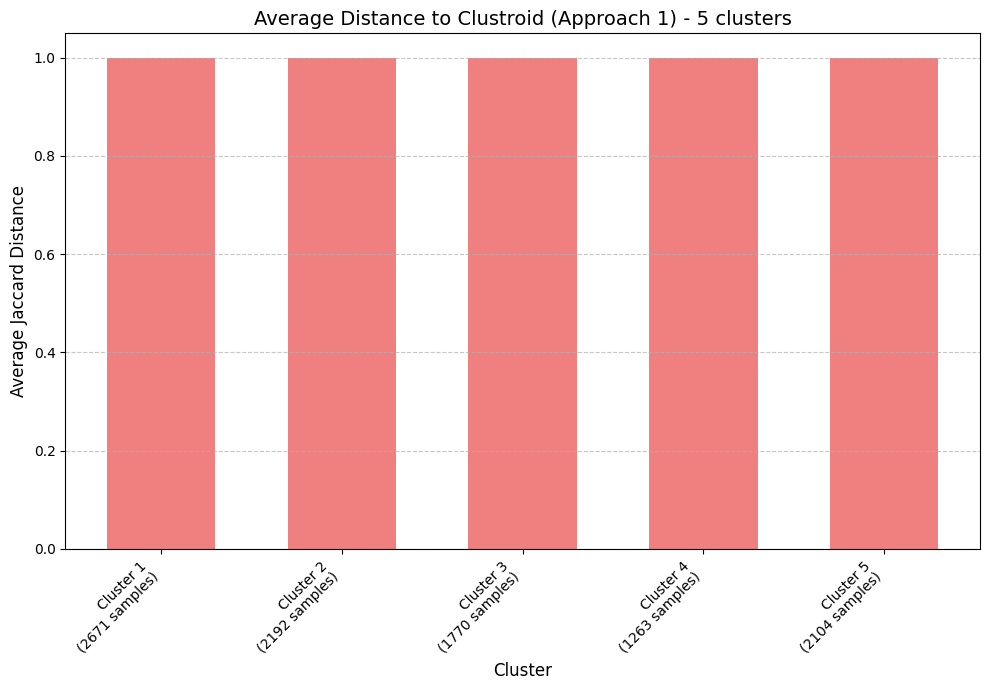

Thời gian thí nghiệm: 0.98 giây
Tổng thời gian: 1365.20 giây

--- Chạy AHC với số cụm = 6 ---
Initializing 10000 clusters...
Calculating initial pairwise cluster distances for heap...
INFO: Starting clustering. Target: 6 clusters. Initial: 10000 clusters. Threshold ratio for diameter stop: 1.2
--- Clustering finished in 1333.04 seconds ---
INFO: Clustering reached target number of 6 clusters.
Final number of active_cluster_ids: 6

--- Final Cluster Details ---
Số cụm tạo được: 6


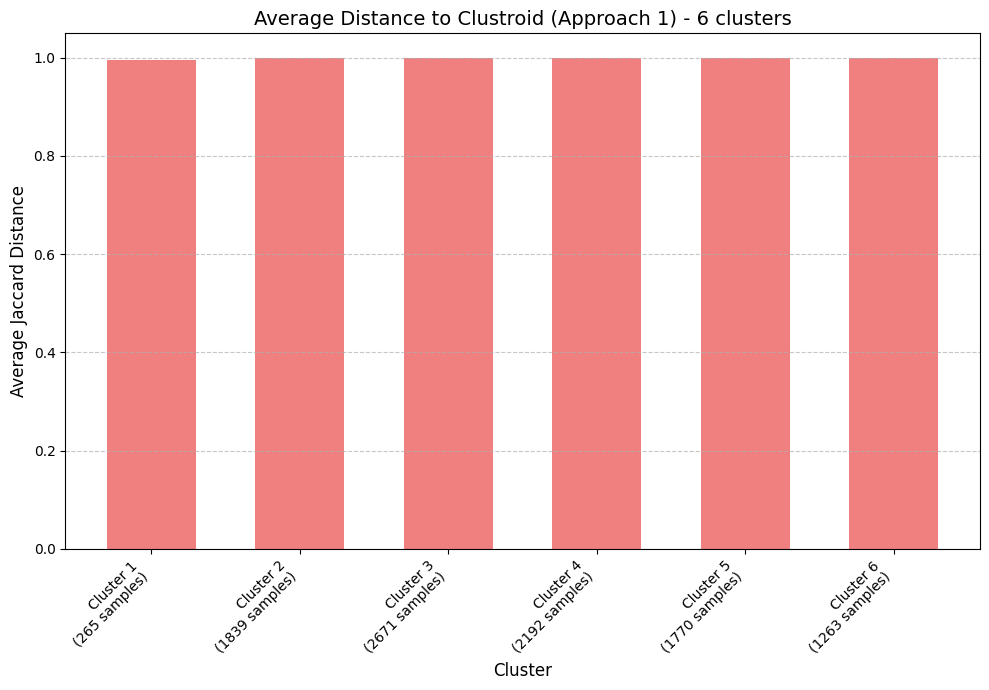

Thời gian thí nghiệm: 0.87 giây
Tổng thời gian: 2702.76 giây

--- Chạy AHC với số cụm = 7 ---
Initializing 10000 clusters...
Calculating initial pairwise cluster distances for heap...
INFO: Starting clustering. Target: 7 clusters. Initial: 10000 clusters. Threshold ratio for diameter stop: 1.2
--- Clustering finished in 1116.75 seconds ---
INFO: Clustering reached target number of 7 clusters.
Final number of active_cluster_ids: 7

--- Final Cluster Details ---
Số cụm tạo được: 7


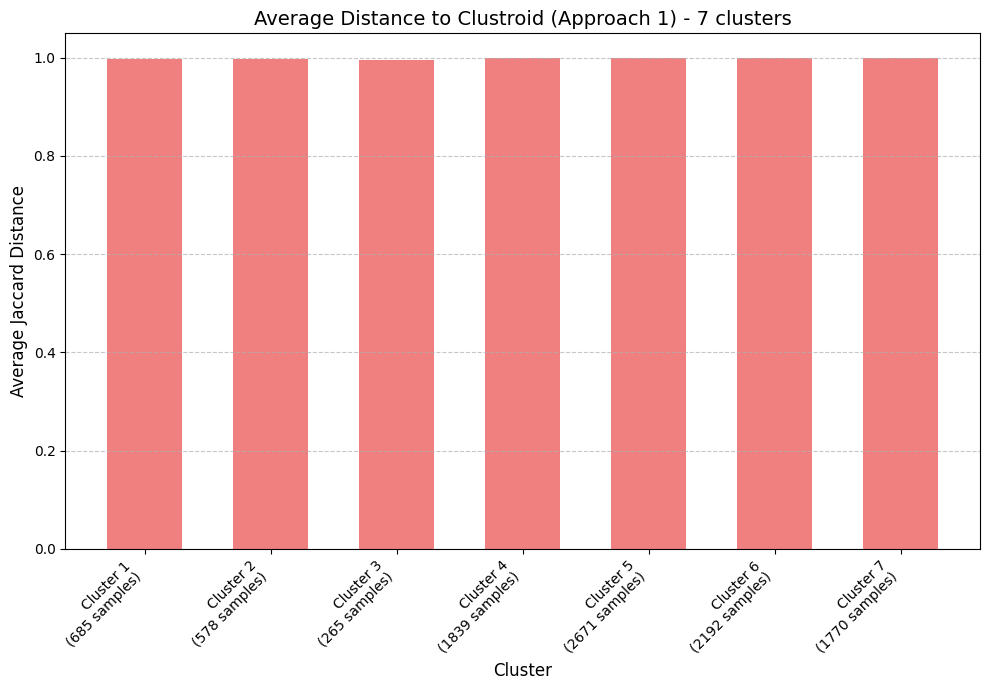

Thời gian thí nghiệm: 0.70 giây
Tổng thời gian: 3823.57 giây
Hoàn thành Task 1.


In [5]:
from collections import Counter
import matplotlib.colors as mcolors

print("\n--- Bước 3: Đọc dữ liệu, Chạy AHC và Thí nghiệm ---")
start_time = time.time()
try:
    df_input_data = pd.read_csv(CSV_FILENAME)
except FileNotFoundError:
    print(f"LỖI: File '{CSV_FILENAME}' không tìm thấy.")
    raise SystemExit

df_input_data['shingles'] = df_input_data['shingles'].apply(lambda x: set(ast.literal_eval(x)))
print(f"Đã đọc dữ liệu: {len(df_input_data)} mẫu")
print(f"Thời gian đọc dữ liệu: {time.time() - start_time:.2f} giây")

if SAMPLE_SIZE_FOR_CLUSTERING < len(df_input_data):
    df_for_clustering = df_input_data.sample(n=SAMPLE_SIZE_FOR_CLUSTERING, random_state=42).reset_index(drop=True)
else:
    df_for_clustering = df_input_data.reset_index(drop=True)

list_of_shingle_sets_for_clustering = df_for_clustering['shingles'].tolist()
print(f"Number of samples for clustering: {len(list_of_shingle_sets_for_clustering)}")

# Chạy AHC
for num_clusters in range(5, 8):  # Chạy AHC Từ 5 đến 7
    print(f"\n--- Chạy AHC với số cụm = {num_clusters} ---")
    
    ahc_model = AgglomerativeHierarchicalClustering(distance_metric_func=jaccard_distance)
    final_clusters = ahc_model.fit(list_of_shingle_sets_for_clustering, num_target_clusters=num_clusters)
    final_clusters_info = ahc_model.get_final_cluster_details()
    
    print(f"Số cụm tạo được: {len(final_clusters_info)}")


    # Tính khoảng cách trung bình
    start_time = time.time()
    avg_dist_to_clustroid_per_cluster = []
    cluster_sizes_for_plotting = []
    for cluster_idx, cluster_data in enumerate(final_clusters_info):
        clustroid_shingles = cluster_data['clustroid_shingles']
        member_shingles = cluster_data['member_shingle_sets']
        if not member_shingles or clustroid_shingles is None:
            avg_dist_to_clustroid_per_cluster.append(0)
            cluster_sizes_for_plotting.append(0)
            continue
        total_dist = sum(jaccard_distance(member, clustroid_shingles) for member in member_shingles)
        num_members = len(member_shingles)
        avg_dist = total_dist / num_members if num_members > 0 else 0
        avg_dist_to_clustroid_per_cluster.append(avg_dist)
        cluster_sizes_for_plotting.append(num_members)
#     print(f"Cluster {cluster_idx+1}: Avg Distance = {avg_dist:.4f}, Number of Samples = {num_members}")

    # Vẽ biểu đồ
    if avg_dist_to_clustroid_per_cluster:
        N_clusters = len(avg_dist_to_clustroid_per_cluster)

        fig_width = max(10, N_clusters * 0.8) # Tăng chiều rộng một chút cho mỗi cụm
        fig_width = min(fig_width, 30) 
        fig_height = 7
        plt.figure(figsize=(fig_width, fig_height))

        bar_labels_full = [f'Cluster {i+1}\n({cluster_sizes_for_plotting[i]} samples)' for i in range(N_clusters)]
    
        plt.bar(range(N_clusters), avg_dist_to_clustroid_per_cluster, color='lightcoral', width=0.6)
    
        plt.xlabel("Cluster", fontsize=12)
        plt.ylabel("Average Jaccard Distance", fontsize=12)
        plt.title(f"Average Distance to Clustroid (Approach 1) - {N_clusters} clusters", fontsize=14)
    
        if N_clusters > 0:
            if N_clusters <= 15: # Nếu ít cụm, hiển thị tất cả nhãn xoay 45 độ
                plt.xticks(ticks=range(N_clusters), labels=bar_labels_full, rotation=45, ha="right", fontsize=10)
            elif N_clusters <= 30: # Nhiều hơn một chút, xoay 90 độ, font nhỏ hơn
                plt.xticks(ticks=range(N_clusters), labels=bar_labels_full, rotation=90, ha="right", fontsize=8)
            else: 
                step = max(1, N_clusters // 15) 
                shown_ticks_indices = range(0, N_clusters, step)
                actual_ticks_positions = list(shown_ticks_indices)
                actual_tick_labels = [bar_labels_full[i] for i in shown_ticks_indices]
                plt.xticks(ticks=actual_ticks_positions, labels=actual_tick_labels, rotation=90, ha="right", fontsize=8)
                plt.xlabel(f"Clustroid (Showing selected labels for {N_clusters} clusters)", fontsize=12)

        if N_clusters > 0:
            min_val_dist = 0.0 # Luôn muốn bắt đầu từ 0 cho khoảng cách
            max_val_dist = max(avg_dist_to_clustroid_per_cluster) if avg_dist_to_clustroid_per_cluster else 1.0

            # Để tạo biểu đồ giống như bạn muốn (thanh cao gần 1.0), trục Y nên là [0, 1.0] hoặc hơn một chút
            y_lower_bound = 0.0
            y_upper_bound = max(1.0, max_val_dist + 0.05) # Đảm bảo ít nhất đến 1.0, và có chút đệm
        
            plt.ylim(y_lower_bound, y_upper_bound)

        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        print("Không có dữ liệu khoảng cách trung bình để vẽ biểu đồ.")

    print(f"Thời gian thí nghiệm: {time.time() - start_time:.2f} giây")

    print(f"Tổng thời gian: {time.time() - start_time_total:.2f} giây")
print("Hoàn thành Task 1.")